# Entrenamiento internet

In [1]:
import os

# Dataset
SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "it"
SUBSET = False
PERCENT_SUBSET = 0.1

# Train
LR = 1e-5
EPOCHS = 100000
GPUS = 1
GPU_NUMBER = 0
if GPUS > 1:
    BS = 120
else:
    if SUBSET:
        BS = 128
    else:
        BS = 56
print(f"BS: {BS}")
LR_SCHEDULER = False
SAVE_BEST_MODEL = False
STOP_AT_TIME = False

# Model
MODEL_PATH = f"model"
if os.path.exists(MODEL_PATH):
    files = os.listdir(MODEL_PATH)
    model_files = [file for file in files if "transformer" in file]
    if len(model_files) > 0:
        name = model_files[0].split(".")[0]
        STEP0 = int(name.split("_")[-1])
        EPOCH0 = int(name.split("_")[-2])
    else:
        EPOCH0 = 0
        STEP0 = 0
else:
    EPOCH0 = 0
    STEP0 = 0
print(f"EPOCH0: {EPOCH0}, STEP0: {STEP0}")
DIM_EMBEDDING = 512
NUM_HEADS = 8
NUM_LAYERS = 6
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1

# Tokenizers
TOKENIZERS_PATH = f"tokenizers"
if not os.path.exists(TOKENIZERS_PATH):
    os.makedirs(TOKENIZERS_PATH)
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
START_OF_SEQUENCE = "[SOS]"
END_OF_SEQUENCE = "[EOS]"

BS: 56
EPOCH0: 0, STEP0: 0


In [2]:
# TODOs
# TODO: Cambiar el dataset
# TODO: Podar el transformer
# TODO: Entrenar en paralelo
# TODO: Ajustar bien los parámetros del LR scheduler

## Device ✔

In [3]:
import torch

if torch.cuda.device_count() > 1 and GPUS > 1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.device_count()} GPUs")
else:
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{GPU_NUMBER}")
        print(f"Using GPU {GPU_NUMBER}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

Using GPU 0


## Carga de los datos ✔

Cargamos el dataset

In [4]:
from datasets import load_dataset

if SUBSET:
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split='train')
    len_dataset = len(dataset_raw)
    len_subset = int(len_dataset * PERCENT_SUBSET)
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split=f'train[:{len_subset}]')
else:
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split='train')

len(dataset_raw)

Found cached dataset opus_books (/home/wallabot/.cache/huggingface/datasets/opus_books/en-it/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf)


32332

Vamos a ver cómo es el dataset

In [5]:
dataset_raw

Dataset({
    features: ['id', 'translation'],
    num_rows: 32332
})

Vemos que es una tupla de con dos características cada elemento, la primera la id y la segunda el texto.

Vamos a ver el primer elemento de la tupla

In [6]:
dataset_raw[0]

{'id': '0',
 'translation': {'en': 'Source: Project Gutenberg',
  'it': 'Source: www.liberliber.it/Audiobook available here'}}

Veamos ahora el segundo elemento de la tupla

In [7]:
dataset_raw[1]

{'id': '1', 'translation': {'en': 'Jane Eyre', 'it': 'Jane Eyre'}}

Vemos que el `id` no nos aporta mucha información, por lo que no lo usaremos

Vamos ahora a ver el elemento `translation`

In [8]:
dataset_raw[2]['translation']

{'en': 'Charlotte Bronte', 'it': 'Charlotte Brontë'}

Cada elemento `translation` es un diccionario con el texto en el idioma original y el texto traducido

## Entrenamiento de los tokenizers ✔

Vamos a entrenar un tokenizer para cada idioma. Podríamos utilizar uno ya preentrenado, pero a veces entrenar uno propio puede dar mejores resultados.

In [9]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [10]:
def get_all_sentences(dataset):
    all_sentences = []
    for i in range(len(dataset)):
        all_sentences.append(dataset[i]['translation'][SOURCE_LANGUAGE])
        all_sentences.append(dataset[i]['translation'][TARGET_LANGUAGE])
    return all_sentences

Entrenamos el tokenizer para el idioma original

In [11]:
tokenizer_source_path = f"{TOKENIZERS_PATH}/tokenizer_{SOURCE_LANGUAGE}.json"

if not os.path.exists(tokenizer_source_path) or STEP0 == 0 or EPOCH0 == 0:
    print(f"Training source tokenizer")
    tokenizer_source = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_source.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw)
    tokenizer_source.train_from_iterator(all_sentences, trainer)
    tokenizer_source.save(tokenizer_source_path)
else:
    tokenizer_source = Tokenizer.from_file(tokenizer_source_path)

Training source tokenizer


Vamos a ver cómo es el tokenizer

In [12]:
with open(tokenizer_source_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

Entrenamos el tokenizer para el idioma traducido

In [13]:
tokenizer_target_path = f"{TOKENIZERS_PATH}/tokenizer_{TARGET_LANGUAGE}.json"

if not os.path.exists(tokenizer_target_path) or STEP0 == 0 or EPOCH0 == 0:
    print(f"Training target tokenizer")
    tokenizer_target = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_target.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw)
    tokenizer_target.train_from_iterator(all_sentences, trainer)
    tokenizer_target.save(tokenizer_target_path)
else:
    tokenizer_target = Tokenizer.from_file(tokenizer_target_path)

Training target tokenizer


Vamos a ver cómo es el tokenizer

In [14]:
with open(tokenizer_target_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

## Obtención de la lóngitud máxima de las secuencias ✔

In [15]:
max_source_sequence_length = 0
max_target_sequence_length = 0

for i in range(len(dataset_raw)):
    source_sequence_length = len(tokenizer_source.encode(dataset_raw[i]['translation'][SOURCE_LANGUAGE]).ids)
    target_sequence_length = len(tokenizer_target.encode(dataset_raw[i]['translation'][TARGET_LANGUAGE]).ids)
    if source_sequence_length > max_source_sequence_length:
        max_source_sequence_length = source_sequence_length
    if target_sequence_length > max_target_sequence_length:
        max_target_sequence_length = target_sequence_length

max_sequence_len = max(max_source_sequence_length, max_target_sequence_length)
max_sequence_len += 2   # Add 2 for the start and end of sequence tokens

print(f"Max source sequence length: {max_source_sequence_length}")
print(f"Max target sequence length: {max_target_sequence_length}")
print(f"Max sequence length: {max_sequence_len}")

Max source sequence length: 309
Max target sequence length: 274
Max sequence length: 311


## Datasets ✔

### Mask ✔

In [16]:
# def create_mask(size):
#     mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
#     return mask == 0
def create_mask(sequence_len):
    mask = torch.tril(torch.ones((1, sequence_len, sequence_len)))
    return mask

### Dataset class ✔

In [17]:
import torch
from torch.utils.data import Dataset

class BilingualDataset(Dataset):
    def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, max_seq_len) -> None:
        super().__init__()
        
        self.max_seq_len = max_seq_len
        self.dataset = dataset
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id(START_OF_SEQUENCE)], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id(END_OF_SEQUENCE)], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id(PADDING_TOKEN)], dtype=torch.int64)
        self.unk_token = torch.tensor([tokenizer_tgt.token_to_id(UNKNOWN_TOKEN)], dtype=torch.int64)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # Getting the source and target texts from the dataset
        src_target_pair = self.dataset[index]['translation']
        src_text = src_target_pair[self.src_lang]
        tgt_text = src_target_pair[self.tgt_lang]
        
        # Tokenizing source and target texts 
        encoder_input_tokens = self.tokenizer_src.encode(src_text).ids
        decoder_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        
        # Computing how many padding tokens need to be added to the tokenized texts 
        encoder_num_padding_tokens = self.max_seq_len - len(encoder_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        decoder_num_padding_tokens = self.max_seq_len - len(decoder_input_tokens) - 1 # Subtracting the '[SOS]' special token
        
        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if encoder_num_padding_tokens < 0 or decoder_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
         
        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(encoder_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * encoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token 
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token 
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
            ]
        )
        
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.max_seq_len
        assert decoder_input.size(0) == self.max_seq_len
        assert label.size(0) == self.max_seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input, 
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }


Veamos una muestra

In [18]:
from random import randint

sample_dataset = BilingualDataset(dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
idx = randint(0, len(sample_dataset))
sample_dataset = sample_dataset[idx]

print(f"Encoder input shape: {sample_dataset['encoder_input'].shape}")
print(f"Decoder input shape: {sample_dataset['decoder_input'].shape}")
print(f"Label shape: {sample_dataset['label'].shape}")
print(f"Source text: {sample_dataset['src_text']}")
print(f"Target text: {sample_dataset['tgt_text']}")

Encoder input shape: torch.Size([311])
Decoder input shape: torch.Size([311])
Label shape: torch.Size([311])
Source text: "Oh, a trifle! Nothing of course to speak of--twenty thousand pounds, I think they say--but what is that?"
Target text: — Ventimila sterline.


### Split dataset ✔

Ahora que vemos que está bien, creamos los datasets de entrenamiento y validación

In [19]:
from torch.utils.data import random_split

percent_train = 0.99
len_train = int(len(dataset_raw) * percent_train)
len_val = len(dataset_raw) - len_train
train_dataset_raw, validation_dataset_raw = random_split(dataset_raw, [len_train, len_val])

print(f"Len train: {len(train_dataset_raw)}, len validation: {len(validation_dataset_raw)}")

Len train: 32008, len validation: 324


In [20]:
train_dataset = BilingualDataset(train_dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
validation_dataset = BilingualDataset(validation_dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)

## Dataloaders ✔

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BS, shuffle=True)


Vamos a ver una muestra

In [22]:
batch = next(iter(train_dataloader))
type(batch)

dict

Como vemos la muestra es un diccionario, vamos a ver sus claves

In [23]:
batch.keys()

dict_keys(['encoder_input', 'decoder_input', 'label', 'src_text', 'tgt_text'])

Las claves son las salidas que habíamos definido en el dataset. Vamos a ver ahora cómo es cada una de las claves

In [24]:
batch['encoder_input'].shape, batch['decoder_input'].shape, batch['label'].shape, len(batch['src_text']), len(batch['tgt_text'])

(torch.Size([56, 311]), torch.Size([56, 311]), torch.Size([56, 311]), 56, 56)

Cada una de las claves tiene tantas muestras como hemos definido en el batch size (`BS`). Vamos ahora a ver una de las muestras

In [25]:
idx = randint(0, BS)

print(f"Encoder input shape: {batch['encoder_input'][idx].shape}")
print(f"Decoder input shape: {batch['decoder_input'][idx].shape}")
print(f"Label shape: {batch['label'][idx].shape}")
print(f"Source text: {batch['src_text'][idx]}")
print(f"Target text: {batch['tgt_text'][idx]}")

Encoder input shape: torch.Size([311])
Decoder input shape: torch.Size([311])
Label shape: torch.Size([311])
Source text: Everything did itself.
Target text: Qui tutto andava da sé.


## Modelo ✔

Volvemos a escribir todo el código del transformer y creamos un objeto de este

### Clases de bajo nivel

In [26]:
import torch
import torch.nn as nn
import torch.nn.init as init

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')
        if self.linear.bias is not None:
            init.zeros_(self.linear.bias)
    
    def forward(self, x):
        return self.linear(x)

class CustomEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(CustomEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        init.xavier_uniform_(self.embedding.weight)
    
    def forward(self, x):
        return self.embedding(x)

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = CustomEmbedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_model_dim):
        super().__init__()
        self.embedding_dim = embedding_model_dim
        positional_encoding = torch.zeros(max_sequence_len, self.embedding_dim)
        for pos in range(max_sequence_len):
            for i in range(0, self.embedding_dim, 2):
                positional_encoding[pos, i]     = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / self.embedding_dim))))
                positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i+1)) / self.embedding_dim))))
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        x = x * torch.sqrt(torch.tensor(self.embedding_dim))
        sequence_len = x.size(1)
        x = x + self.positional_encoding[:,:sequence_len]
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, query, key, value, mask=None):
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float('-inf'))
        attention_matrix = torch.softmax(scale, dim=-1)
        output = torch.matmul(attention_matrix, value)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, dim_embedding):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.dim_proyection = dim_embedding // heads
        self.heads = heads
        self.proyection_Q = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_K = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_V = CustomLinear(dim_embedding, dim_embedding)
        self.attention = CustomLinear(dim_embedding, dim_embedding)
        self.scaled_dot_product_attention = ScaledDotProductAttention(self.dim_proyection)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        proyection_Q = self.proyection_Q(Q).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_K = self.proyection_K(K).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_V = self.proyection_V(V).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_Q = proyection_Q.transpose(1,2)
        proyection_K = proyection_K.transpose(1,2)
        proyection_V = proyection_V.transpose(1,2)
        scaled_dot_product_attention = self.scaled_dot_product_attention(proyection_Q, proyection_K, proyection_V, mask=mask)
        concat = scaled_dot_product_attention.transpose(1,2).contiguous().view(batch_size, -1, self.dim_embedding)
        output = self.attention(concat)
        return output

class AddAndNorm(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.normalization = nn.LayerNorm(dim_embedding)

    def forward(self, x, sublayer):
        return self.normalization(torch.add(x, sublayer))

class FeedForward(nn.Module):
    def __init__(self, dim_embedding, increment=4):
        super().__init__()
        self.feed_forward = nn.Sequential(
            CustomLinear(dim_embedding, dim_embedding*increment),
            nn.ReLU(),
            CustomLinear(dim_embedding*increment, dim_embedding)
        )
    
    def forward(self, x):
        x = self.feed_forward(x)
        return x

class Linear(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.softmax(x)
        return x

class Dropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return torch.nn.functional.dropout(x, p=self.p)
        else:
            return x


### Clases de medio nivel

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
    
    def forward(self, x):
        multi_head_attention = self.multi_head_attention(x, x, x)
        dropout1 = self.dropout_1(multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(x, dropout1)
        feed_forward = self.feed_forward(add_and_norm_1)
        dropout2 = self.dropout_2(feed_forward)
        add_and_norm_2 = self.add_and_norm_2(add_and_norm_1, dropout2)
        return add_and_norm_2

class Encoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.input_embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
    
    def forward(self, x):
        input_embedding = self.input_embedding(x)
        positional_encoding = self.positional_encoding(input_embedding)
        encoder = self.encoder(positional_encoding)
        return encoder

class DecoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.encoder_decoder_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_3 = Dropout(prob_dropout)
        self.add_and_norm_3 = AddAndNorm(dim_embedding)
    
    def forward(self, x, encoder_output, mask=None):
        Q = x
        K = x
        V = x
        masked_multi_head_attention = self.masked_multi_head_attention(Q, K, V, mask=mask)
        dropout1 = self.dropout_1(masked_multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(dropout1, x)

        Q = add_and_norm_1
        K = encoder_output
        V = encoder_output
        encoder_decoder_multi_head_attention = self.encoder_decoder_multi_head_attention(Q, K, V)
        dropout2 = self.dropout_2(encoder_decoder_multi_head_attention)
        add_and_norm_2 = self.add_and_norm_2(dropout2, add_and_norm_1)

        feed_forward = self.feed_forward(add_and_norm_2)
        dropout3 = self.dropout_3(feed_forward)
        add_and_norm_3 = self.add_and_norm_3(dropout3, add_and_norm_2)

        return add_and_norm_3

class Decoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x, encoder_output, mask=None):
        for decoder_layer in self.layers:
            x = decoder_layer(x, encoder_output, mask)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout=0.1):
        super().__init__()
        self.embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.linear = Linear(dim_embedding, vocab_size)
        # self.softmax = Softmax()
    
    def forward(self, x, encoder_output, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.decoder(x, encoder_output, mask)
        x = self.linear(x)
        # x = self.softmax(x)
        return x

class Linear_and_softmax(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        # self.softmax = Softmax()
    
    def forward(self, x):
        x = self.linear(x)
        # x = self.softmax(x)
        return x


### Clase de alto nivel

In [28]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_max_seq_len, tgt_max_seq_len, dim_embedding, Nx, heads, prob_dropout=0.1):
        super().__init__()
        self.transformerEncoder = TransformerEncoder(src_vocab_size, dim_embedding, src_max_seq_len, heads, Nx, prob_dropout)
        self.transformerDecoder = TransformerDecoder(heads, dim_embedding, Nx, tgt_vocab_size, tgt_max_seq_len, prob_dropout)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.sourceEmbedding = Embedding(src_vocab_size, dim_embedding)
        self.targetEmbedding = Embedding(tgt_vocab_size, dim_embedding)
        self.sourcePositional_encoding = PositionalEncoding(src_max_seq_len, dim_embedding)
        self.targetPositional_encoding = PositionalEncoding(tgt_max_seq_len, dim_embedding)
        self.linear = Linear_and_softmax(dim_embedding, tgt_vocab_size)
    
    def encode(self, source):
        embedding = self.sourceEmbedding(source)
        positional_encoding = self.sourcePositional_encoding(embedding)
        encoder_output = self.encoder(positional_encoding)
        return encoder_output
    
    def decode(self, encoder_output, target, target_mask):
        embedding = self.targetEmbedding(target)
        positional_encoding = self.targetPositional_encoding(embedding)
        decoder_output = self.decoder(positional_encoding, encoder_output, target_mask)
        return decoder_output
    
    def projection(self, decoder_output):
        linear_output = self.linear(decoder_output)
        # softmax_output = self.softmax(linear_output)
        return linear_output
    
    def forward(self, source, target, target_mask):
        # Encode
        embedding_encoder = self.sourceEmbedding(source)
        positional_encoding_encoder = self.sourcePositional_encoding(embedding_encoder)
        encoder_output = self.encoder(positional_encoding_encoder)

        # Decode
        embedding_decoder = self.targetEmbedding(target)
        positional_encoding_decoder = self.targetPositional_encoding(embedding_decoder)
        decoder_output = self.decoder(positional_encoding_decoder, encoder_output, target_mask)

        # Projection
        proj_output = self.linear(decoder_output)
        return proj_output


### Transformer

In [29]:
source_vocab_size = tokenizer_source.get_vocab_size()
target_vocab_size = tokenizer_target.get_vocab_size()
src_max_seq_len = max_sequence_len
tgt_max_seq_len = max_sequence_len
dim_embedding = DIM_EMBEDDING
Nx = NUM_LAYERS
heads = NUM_HEADS
prob_dropout = DROPOUT
print(f"source vocab size: {source_vocab_size}, target vocab size: {target_vocab_size}, source max sequence len: {src_max_seq_len}, target max sequence len: {tgt_max_seq_len}, dim_embedding: {dim_embedding}, heads: {heads}, Nx: {Nx}, prob_dropout: {prob_dropout}")

model = Transformer(
    src_vocab_size = source_vocab_size,
    tgt_vocab_size = target_vocab_size,
    src_max_seq_len = src_max_seq_len,
    tgt_max_seq_len = tgt_max_seq_len,
    dim_embedding = dim_embedding,
    Nx = Nx,
    heads = heads,
    prob_dropout = prob_dropout,
)

model.to(device)
print("")

source vocab size: 30000, target vocab size: 30000, source max sequence len: 311, target max sequence len: 311, dim_embedding: 512, heads: 8, Nx: 6, prob_dropout: 0.1


In [30]:
# Data parallel
# if torch.cuda.device_count() > 1 and GPUS > 1:
#     number_gpus = torch.cuda.device_count()
#     print(f"Let's use {number_gpus} GPUs!")
#     transformer = nn.DataParallel(transformer)

#     # def create_mask(sequence_len):
#     #     mask = torch.tril(torch.ones((2*sequence_len, sequence_len)))
#     #     return mask
#     def create_mask(sequence_len):
#         mask = torch.triu(torch.ones(1, 2*sequence_len, sequence_len), diagonal = 1).type(torch.int)
#         return mask == 0
# else:
#     number_gpus = 1
#     print(f"Let's use {number_gpus} GPUs! GPU NUMBER: {GPU_NUMBER}")
    
#     # def create_mask(sequence_len):
#     #     mask = torch.tril(torch.ones((sequence_len, sequence_len)))
#     #     return mask
#     def create_mask(sequence_len):
#         mask = torch.triu(torch.ones(1, sequence_len, sequence_len), diagonal = 1).type(torch.int)
#         return mask == 0


In [31]:
mask = create_mask(max_sequence_len)
mask.shape

torch.Size([1, 311, 311])

## Entrenamiento

### Optimizador ✔

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

### Función de pérdida ✔

Creamos la función de pérdida con label smoothing

In [33]:
loss_fn = nn.CrossEntropyLoss(
    ignore_index = tokenizer_source.token_to_id(PADDING_TOKEN), 
    label_smoothing = LABEL_SMOOTHING).to(device)


### LR ✔

In [34]:
class Step():
    def __init__(self):
        self.step = 0
    
    def set_step(self, st):
        self.step = st
    
    def get_step(self):
        return int(self.step)

class LearningRate():
    def __init__(self):
        self.lr = 0
    
    def set_lr(self, l_r_):
        self.lr = l_r_
    
    def get_lr(self):
        return self.lr

actual_step = Step()
actual_lr = LearningRate()

Ahora vamos a crear la función que calcula el learning rate en función del step. Como vimos, en el paper dicen que usan la fórmula

$$lr = d_{model}^{-0.5} \cdot min \left(stepNumber^{-0.5}, stepNumber \cdot stepWarmUp^{-1.5} \right)$$

Sin embargo, con nuestro batch size y el número de épocas, el learning rate evolucionaría así

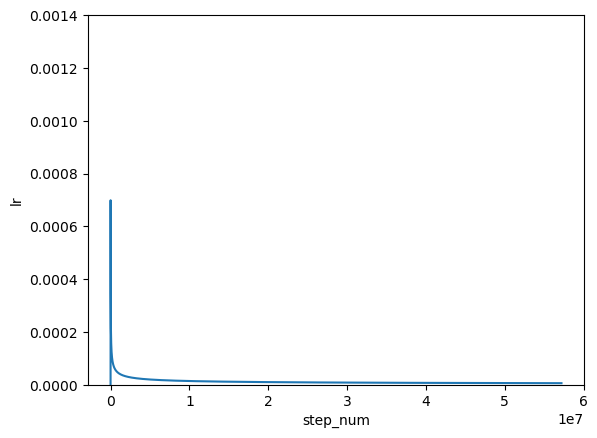

In [35]:
import numpy as np
import matplotlib.pyplot as plt

warmup_steps = 4000
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.5
warmup_steps_exp = -1.5
dim_embedding_exp = -0.5
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.xlabel('step_num')
plt.ylabel('lr')
plt.ylim(0, 0.0014)
plt.show()

Como se puede ver sube muy rápido y luego baja muy rápido a un valor tan pequeño que es casi como si no hubiera learning rate. Por lo que los pesos de la red neuronal apenas se van a actualizar. Por lo que probando voy a usar esta fórmula

$$lr = d_{model}^{-0.1} \cdot min \left(stepNumber^{-0.4}, stepNumber \cdot stepWarmUp^{-2.6} \right)$$

Con lo que el learning rate evolucionaría así

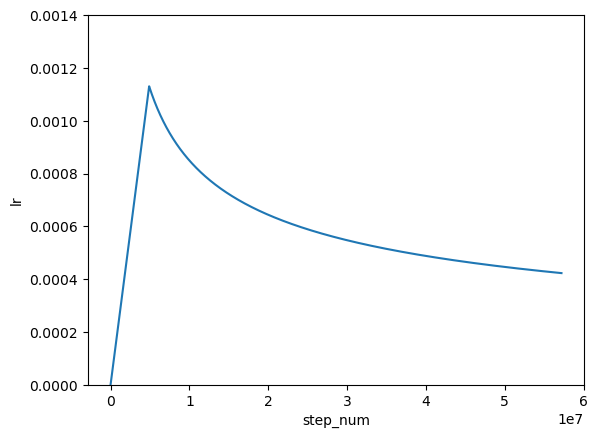

In [36]:
warmup_steps = 4000
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.4
warmup_steps_exp = -2.6
dim_embedding_exp = -0.1
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.xlabel('step_num')
plt.ylabel('lr')
plt.ylim(0, 0.0014)
plt.show()

In [37]:
import numpy as np

def calculate_lr(step_num, dim_embeding_model=512, warmup_steps=4000):
    step_num += 1e-7 # Avoid division by zero
    step_num += STEP0
    actual_step.set_step(step_num)
    step_num_exp = -0.4
    warmup_steps_exp = -2.6
    dim_embeding_model_exp = -0.1
    lr = np.power(dim_embeding_model, dim_embeding_model_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))
    actual_lr.set_lr(lr)
    return lr

lr_lambda = lambda step: calculate_lr(step, dim_embeding_model=dim_embedding)
if LR_SCHEDULER:
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Validation loop ✔

In [38]:
def greedy_decode(model, source, tokenizer_tgt, max_len, device, bs):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')    # Start of Sentence token index (2)
    # eos_idx = tokenizer_tgt.token_to_id('[EOS]')    # End of Sentence token index (3)

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source)
    
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(bs,1).fill_(sos_idx).type_as(source).to(device)
    
    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break
            
        # Building a mask for the decoder input
        decoder_mask = create_mask(decoder_input.size(1)).to(device)
        
        # Calculating the output of the decoder
        out = model.decode(encoder_output, decoder_input, decoder_mask)
        
        # Applying the projection layer to get the probabilities for the next token
        prob = model.projection(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        # decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)
        decoder_input = torch.cat([decoder_input, next_word.unsqueeze(1)], dim=1)
    
    if len(decoder_input.shape) == 1:
        decoder_input = decoder_input.unsqueeze(0)
    elif len(decoder_input.shape) == 3:
        decoder_input = decoder_input.squeeze(0)

    return decoder_input # Sequence of tokens generated by the decoder


In [39]:
from tqdm import tqdm

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

def validation_loop(model, validation_ds, tokenizer_tgt, max_len, device):
    model.eval() # Setting model to evaluation mode

    # Calculating the number of batches in the validation dataset
    dataset_size = len(validation_ds.dataset)  # Tamaño total del conjunto de datos
    batch_size = validation_ds.batch_size      # Tamaño del batch
    drop_last = validation_ds.drop_last        # Configuración de drop_last
    num_batches = len(validation_ds)           # Número total de batches

    # Calculating the total number of samples in the validation dataset
    total_samples = batch_size * (num_batches - 1) + min(batch_size, dataset_size % batch_size)

    # If drop_last is False and the dataset size is not divisible by the batch size, we need to add one more batch
    if drop_last and dataset_size % batch_size != 0:
        total_samples -= dataset_size % batch_size

    # Initializing progress bar
    progress_bar = tqdm(range(total_samples), desc = 'Processing validation examples') # Initializing progress bar

    # Initializing lists to store scores
    bleu_scores = []
    meteor_scores = []
    
    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            
            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            num_samples = len(batch['src_text'])
            model_out_bs = greedy_decode(model, encoder_input, tokenizer_tgt, max_len, device, num_samples)

            # Get metrics for every example in the batch
            for i in range(num_samples):
                source_text = batch['src_text'][i]
                target_text = batch['tgt_text'][i]
                model_out_i = model_out_bs[i]
                model_out_text = tokenizer_tgt.decode(model_out_i.detach().cpu().numpy())

                # Calculating metrics
                references = [target_text.split()]
                hypothesis = model_out_text.split()
                bleu_score = sentence_bleu(references, hypothesis)
                meteor_score_value = meteor_score(references, hypothesis)
            
                # Appending scores to lists
                bleu_scores.append(bleu_score)
                meteor_scores.append(meteor_score_value)

                # Calculating mean scores            
                mean_bleu_score = sum(bleu_scores)/len(bleu_scores) # Calculating mean BLEU score
                mean_meteor_score = sum(meteor_scores)/len(meteor_scores) # Calculating mean METEOR score

                # Updating progress bar and printing bleu and meteor scores
                progress_bar.update(1)
                progress_bar.set_postfix({'BLEU': f'{mean_bleu_score:.9f}', 'METEOR': f'{mean_meteor_score:.9f}'})

    # Printing results
    console_width = 80 # Fixed witdh for printed messages
    print('-'*console_width)
    print(f'SOURCE: {source_text}')
    print(f'TARGET: {target_text}')
    print(f'PREDICTED: {model_out_text}')
    print('-'*console_width)

    return mean_bleu_score, mean_meteor_score


### Train loop ✔

In [40]:
def train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer, lr_scheduler=None):
    # Initializing an iterator over the training dataloader
    # We also use tqdm to display a progress bar
    print()
    batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
    
    # For each batch...
    for batch in batch_iterator:
        model.train() # Train the model
            
        # Loading input data and masks onto the GPU
        encoder_input = batch['encoder_input'].to(device)
        decoder_input = batch['decoder_input'].to(device)
        decoder_mask = create_mask(decoder_input.size(1)).to(device)
        
        # Running tensors through the Transformer
        proj_output = model(encoder_input, decoder_input, decoder_mask)
        
        # Loading the target labels onto the GPU
        label = batch['label'].to(device)
        
        # Computing loss between model's output and true labels
        loss = loss_fn(proj_output.view(-1, tokenizer_target.get_vocab_size()), label.view(-1))
        
        # Updating progress bar, print loss and lr
        batch_iterator.set_postfix({'loss': f'{loss.item():.6f}', 'lr': f'{actual_lr.get_lr():.9f}'})
        
        # Performing backpropagation
        loss.backward()
        
        # Updating parameters based on the gradients
        optimizer.step()
        
        # Clearing the gradients to prepare for the next batch
        optimizer.zero_grad()

        # Update step and LR
        if LR_SCHEDULER:
            lr_scheduler.step()
        
    return loss.item(), actual_lr.get_lr()

### Train

In [41]:
import time

def elapsed_time(t0):
    t = time.time() - t0  # tiempo transcurrido en segundos

    # Convertir el tiempo a días, horas, minutos y segundos
    days, t = divmod(t, 86400)  # 86400 segundos en un día
    hours, t = divmod(t, 3600)  # 3600 segundos en una hora
    minutes, seconds = divmod(t, 60)  # 60 segundos en un minuto

    return int(days), int(hours), int(minutes), int(seconds)

def elapsed_seconds(days, hours, minutes, seconds):
    return days * 86400 + hours * 3600 + minutes * 60 + seconds


In [42]:
if EPOCH0 != 0 or STEP0 != 0:
    weights = f"{MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth"
    print(f"Loading model from {weights}")
    if GPUS > 1:
        model.load_state_dict(torch.load(weights))
    else:
        model = torch.load(weights, map_location=device)
        if isinstance(model, nn.DataParallel):
            print("Transforming model from data parallel to model")
            model = model.module
    print(f"Model loaded from {weights}")

    validation_file_path = f"{MODEL_PATH}/best_validation_bleu_{EPOCH0}_{STEP0}.npy"
    print(f"load best validation loss from {validation_file_path}")
    best_bleu = np.load(validation_file_path)
    print(f"best validation meteor: {best_bleu}")
else:
    best_bleu = 1e-20

print(f"Starting training from epoch {EPOCH0} and step {STEP0}, best bleu: {best_bleu}")


Starting training from epoch 0 and step 0, best bleu: 1e-20


In [43]:
train_loss_list = []
train_lr_list = []
validation_meteor_list = []
validation_bleu_list = []

train_loss_list = np.array(train_loss_list)
train_lr_list = np.array(train_lr_list)
validation_meteor_list = np.array(validation_meteor_list)
validation_bleu_list = np.array(validation_bleu_list)

In [44]:
from tqdm import tqdm

max_seconds = 60*60*11 + 60*30 # 11 horas y 30 minutos
t0 = time.time()

for epoch in range(0, EPOCHS):
    days, hours, minutes, seconds = elapsed_time(t0)
    print(f"\nEpoch {epoch}\n-------------------------------, {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")

    # We run the 'train_loop' function at the beginning of each epoch
    if LR_SCHEDULER:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer, lr_scheduler)    
    else:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer)
        
    # We run the 'run_validation' function at the end of each epoch
    # to evaluate model performance
    validation_meteor, validation_bleu = validation_loop(model, validation_dataloader, tokenizer_target, max_sequence_len, device)

    train_loss_list = np.append(train_loss_list, train_loss)
    train_lr_list = np.append(train_lr_list, train_lr)
    validation_meteor_list = np.append(validation_meteor_list, validation_meteor)
    validation_bleu_list = np.append(validation_bleu_list, validation_bleu)

    if (validation_bleu > best_bleu) and SAVE_BEST_MODEL:
        best_bleu = validation_bleu
        weights = f"{MODEL_PATH}/transformer_{epoch}_{actual_step.get_step()}.pth"
        print(f"Saving model to {weights}")
        if GPUS > 1:
            torch.save(model.state_dict(), weights)
        else:
            torch.save(model, weights)
        print(f"Model saved to {weights}")

        best_bleu_path = f"{MODEL_PATH}/best_validation_bleu_{epoch}_{actual_step.get_step()}.npy"
        print(f"Saving best validation meteor to {best_bleu_path}")
        np.save(best_bleu_path, best_bleu)
        print(f"Best validation meteor saved to {best_bleu_path}")
    
    days, hours, minutes, seconds = elapsed_time(t0)
    if (elapsed_seconds(days, hours, minutes, seconds) > max_seconds) and STOP_AT_TIME:
        print(f"Elapsed time: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")
        break

print("Done")


Epoch 0
-------------------------------, 0 days, 0 hours, 0 minutes, 0 seconds



Processing validation examples: 100%|██████████| 324/324 [01:28<00:00,  3.66it/s, BLEU=0.000000000, METEOR=0.000000000] 


--------------------------------------------------------------------------------
SOURCE: Superstition was with me at that moment; but it was not yet her hour for complete victory: my blood was still warm; the mood of the revolted slave was still bracing me with its bitter vigour; I had to stem a rapid rush of retrospective thought before I quailed to the dismal present.
TARGET: La superstizione si era insinuata nell'anima mia in quel momento; ma essa non trionfava ancora; il sangue mi correva ancora caldo nelle vene; la rabbia della schiava ribelle mi animava ancora con il suo amaro vigore; dovevo trattenere la rapida corsa del pensiero verso il passato prima di lasciarmi abbattere dallo sgomento del presente.
PREDICTED: , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

Processing validation examples:   1%|          | 3/324 [00:14<1:19:32, 14.87s/it, BLEU=0.000000000, METEOR=0.000000000]/home/wallabot/miniconda3/envs/cursopytorch/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wallabot/miniconda3/envs/cursopytorch/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wallabot/miniconda3/envs/cursopytorch/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 

--------------------------------------------------------------------------------
SOURCE: After sitting a while longer, and musing what I should do in this case, I was not able to bear sitting in ignorance longer; so setting up my ladder to the side of the hill, where there was a flat place, as I observed before, and then pulling the ladder after me, I set it up again and mounted the top of the hill, and pulling out my perspective glass, which I had taken on purpose, I laid me down flat on my belly on the ground, and began to look for the place.
TARGET: Dopo essere restato qualche tempo di più in tale perplessità, meditando che cosa si potesse fare nel caso mio, non fui buono di durarla più lungamente e di rimanere per maggior tempo all’oscuro delle cose. Posata quindi la mia scala al lato del monte su cui stava uno spianato, come già dissi, vi salii, poi tiratami da presso la mia scala, me ne valsi per salire la cima del monte; indi livellato il mio cannocchiale, che avea preso meco a 

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.023416849] 


--------------------------------------------------------------------------------
SOURCE: They had hardly entered the marsh when both dogs began searching together and started off toward a rusty-looking spot in the marsh.
TARGET: Erano appena entrati nella palude, che tutti e due i cani cominciarono a cercare insieme e si spinsero verso l’acqua rugginosa.
PREDICTED: Il , , , , , , , , , , , , , , , , , , , , , , , , , ,
--------------------------------------------------------------------------------

Epoch 3
-------------------------------, 0 days, 0 hours, 20 minutes, 5 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.024851000] 


--------------------------------------------------------------------------------
SOURCE: 'I don't know,' she said. 'She said we were not to have any lessons, but must walk with Miss Hull to Grandmamma's.'
TARGET: — Non so — disse. — Non ha detto di studiare, ha detto di andare a spasso con miss Hull dalla nonna.
PREDICTED: — Non — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — —
-----------------------------------------------------

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.022875576] 


--------------------------------------------------------------------------------
SOURCE: I was loth to spend our shot too hastily; so I called my servant, not my man Friday, for he was better employed, for, with the greatest dexterity imaginable, he had charged my fusee and his own while we were engaged—but, as I said, I called my other man, and giving him a horn of powder, I had him lay a train all along the piece of timber, and let it be a large train.
TARGET: Rimastine abbrustoliti quelli che erano sul pancone, sei o sette di essi caddero; ma i più balzati dalla paura e dal bruciore del fuoco, spiccarono un salto entro la nostra trincea, ove facemmo presto a spacciarli. I lupi di fuori spaventati da tale vampa improvvisa che il buio della notte già sopraggiunto rendea più spaventosa, rincularono un poco.
PREDICTED: La , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.019091548] 


--------------------------------------------------------------------------------
SOURCE: "Much better, sir; I shall be well soon."
TARGET: — Molto meglio, signore. Fra poco non avrò altro.
PREDICTED: — Non , , , , , , , , , , , , , , , . . . . . . . .
--------------------------------------------------------------------------------

Epoch 6
-------------------------------, 0 days, 0 hours, 40 minutes, 13 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.020456138] 


--------------------------------------------------------------------------------
SOURCE: I daresay it is only a rat scrambling along the rafters of the adjoining schoolroom: it was a barn before I had it repaired and altered, and barns are generally haunted by rats.
TARGET: Sarà un topo che rosica il muro della scuola; prima che la facessi restaurare era un granaio e i topi bazzicano nei granai.
PREDICTED: " , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.021843579] 


--------------------------------------------------------------------------------
SOURCE: Everything about his face and figure – from his black closely-cropped hair and freshly-shaven chin to his wide, brand-new uniform – was simple and at the same time elegant.
TARGET: Nel viso e nella persona di lui, dai capelli neri dal taglio corto e dal mento rasato di fresco fino all’uniforme ampia e nuova fiammante, tutto era semplice e nello stesso tempo elegante.
PREDICTED: Il , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

Processing validation examples: 100%|██████████| 324/324 [01:28<00:00,  3.68it/s, BLEU=0.000000000, METEOR=0.020965884] 


--------------------------------------------------------------------------------
SOURCE: Stepping lightly and glancing repeatedly at her husband, showing him a brave face full of sympathy she entered the sick-room, and, turning without haste, noiselessly closed the door.
TARGET: Con passo leggero, guardando sempre il marito e mostrandogli un viso coraggioso e compassionevole, ella entrò nella stanza del malato e, voltatasi con calma, chiuse l’uscio senza far rumore.
PREDICTED: Il , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.024868403] 


--------------------------------------------------------------------------------
SOURCE: The Shcherbatskys' hall-porter certainly knew everything.
TARGET: Il portiere degli Šcerbackij sapeva tutto certamente.
PREDICTED: Il ’ ’ ’ ’ ’ ’ ’ ’ ’ il il il il il il il il il il di ’ ’ ’ ’ ’ ’ ’ ’ ’ il di di . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 10
-------------------------------, 0 days, 1 hours, 7 minutes, 4 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.033156920] 


--------------------------------------------------------------------------------
SOURCE: His head drooped and he remained silent, unable to speak.
TARGET: Egli abbassò il capo e tacque. Non poteva dir nulla.
PREDICTED: La si si si e , e e e e e e e e e e e e e e e e e e e e e e e e e e e . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 11
-------------------------------, 0 days, 1 hours, 13 minutes, 47 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.036125736] 


--------------------------------------------------------------------------------
SOURCE: Shaking this off with a gasp and a struggle, I uplifted myself upon the pillows, and, peering earnestly within the intense darkness of the chamber, hearkened—I know not why, except that an instinctive spirit prompted me—to certain low and indefinite sounds which came, through the pauses of the storm, at long intervals, I knew not whence.
TARGET: Respirai con energia, feci uno sforzo, ed arrivai a scuotermi; e sollevandomi sui cuscini, e figgendo ardentemente lo sguardo nella fitta oscurità della camera, tesi l'orecchio, non saprei dire perchè, se non mi ci spinse una forza istintiva, a certi suoni bassi e vaghi che partivano non so di dove, e che m'arrivavano a lunghi intervalli, traverso i riposi della tempesta.
PREDICTED: , ' , ' , e , e , e , e , e , e , e , e , e , e , e , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , ' , , ' , ' , ' , ' , , , ' , , , , , ' , ' , ,

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.047200807] 


--------------------------------------------------------------------------------
SOURCE: Levin's arrival at the beginning of the winter, his frequent visits and evident love for Kitty gave rise to her parents' first serious deliberation as to her future and to disputes between them.
TARGET: L’apparizione di Levin al principio dell’inverno, le visite frequenti e il suo evidente amore per Kitty erano stato l’oggetto dei primi discorsi seri fra i genitori di Kitty sul suo avvenire, e di litigi fra il principe e la principessa.
PREDICTED: Il , ’ , e la , e la , e la , e la , e la , e la , e , e , e , e di . , ’ , ’ . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 13
-------------------------------, 0 days, 1 hours, 27 minutes, 12 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.042868092] 


--------------------------------------------------------------------------------
SOURCE: How stern you look now!
TARGET: Ci rinunciate così presto?
PREDICTED: Come ! ! — ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 14
-------------------------------, 0 days, 1 hours, 33 minutes, 55 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.051057528] 


--------------------------------------------------------------------------------
SOURCE: There is, it must be confessed, something very sad about the early efforts of an amateur in bagpipes.
TARGET: V’è, bisogna confessarlo, qualche cosa di molto triste nei primi esercizî d’un dilettante di cornamusa.
PREDICTED: È un è un è un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un un

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.052595492] 


--------------------------------------------------------------------------------
SOURCE: The night was coming on, and the light began to be dusky, which made it worse on our side; but the noise increasing, we could easily perceive that it was the howling and yelling of those hellish creatures; and on a sudden we perceived three troops of wolves, one on our left, one behind us, and one in our front, so that we seemed to be surrounded with them: however, as they did not fall upon us, we kept our way forward, as fast as we could make our horses go, which, the way being very rough, was only a good hard trot.
TARGET: Cominciava ad imbrunire, perchè s’avvicinava la notte a far la nostra condizione più trista, e lo strepito crescea sempre di più, quando ci accorgemmo che derivava tuttavia da ululati di quelle diaboliche creature. In un subito ne vedemmo tre branchi, uno a sinistra, l’altro a destra, il terzo a fronte di noi, sì che potevamo dire d’essere accerchiati dai lupi.
PREDICTED: , , m

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.058936079] 


--------------------------------------------------------------------------------
SOURCE: 'Go to Mariette,' she said to Serezha, who had come out after her, and she began pacing up and down the straw matting of the verandah.
TARGET: — Va’, va’ da Mariette — disse a Serëza che l’aveva seguita, e si mise a camminare sulla stuoia della terrazza.
PREDICTED: — E , disse — disse , disse , disse , disse , disse , disse , e la la . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 17
-------------------------------, 0 days, 1 hours, 54 minutes, 2 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.053625930] 


--------------------------------------------------------------------------------
SOURCE: No, I am sick of it.
TARGET: No, m’è venuto a noia.
PREDICTED: No , non ho ho . . . . . . . .
--------------------------------------------------------------------------------

Epoch 18
-------------------------------, 0 days, 2 hours, 0 minutes, 44 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.058611960] 


--------------------------------------------------------------------------------
SOURCE: Help me!"... These horses, this carriage, how horrid it is of me to be in this carriage – they are all his, but I shall not see them any more.'
TARGET: Questi cavalli, questo carrozzino, come mi vedo ripugnante in questo carrozzino. Tutto è suo, ma non vedrò più nulla”.
PREDICTED: Ma , è , , ma , ma , ma , ma , ma , ma , ma , ma . , è , è , è . , è , è , è , è , è , è . , è , è , è , è , è . , è , è , è , è , è . , è , è , è , è , è , è . , è , è , è , è , è , è . , è , è , è , è , è , è . , è , è , è , è , è , è . , è , è , è , è . , è , è , è . , è . , è , è , è . , è . , è , è , è , è . , è . , è , è . , è , è , è , , , è , è , è , è , è , è , è , è , è , è , è , è , è , è , è , è , , , , , è , è ,
--------------------------------------------------------------------------------

Epoch 19
-------------------------------, 0 days, 2 hours, 7 minutes, 27 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.055120511] 


--------------------------------------------------------------------------------
SOURCE: Before quitting him for ever, I will tell him everything.
TARGET: Prima di partire per sempre gli dirò tutto.
PREDICTED: Io non , non lui , non lui , e non lui , non lui . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 20
-------------------------------, 0 days, 2 hours, 14 minutes, 8 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.062735590] 


--------------------------------------------------------------------------------
SOURCE: At that moment Agatha Mikhaylovna came in with some jam.
TARGET: In quel momento entrò Agaf’ja Michajlovna con la marmellata.
PREDICTED: Il ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja ja 

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.065861947] 


--------------------------------------------------------------------------------
SOURCE: You won't have got your hat before I am back.'
TARGET: Non farai in tempo a metterti il cappello che sarò qui.
PREDICTED: Non ho la a . . . . . . . .
--------------------------------------------------------------------------------

Epoch 22
-------------------------------, 0 days, 2 hours, 27 minutes, 32 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.063711427] 


--------------------------------------------------------------------------------
SOURCE: Hannah, the servant, was my most frequent visitor. Her coming disturbed me. I had a feeling that she wished me away: that she did not understand me or my circumstances; that she was prejudiced against me.
TARGET: Anna era quella che mi visitava più spesso; non mi faceva piacere di vederla, perché capivo che avrebbe voluto che me ne andassi, che non comprendeva la mia posizione ed era mal disposta verso di me.
PREDICTED: " La mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia , ma mi mia che mi mia che mi mia . . . . . . . .
--------------------------------------------------------------------------------

Epoch 23
-------------------------------, 0 days, 2 hours, 34 minutes, 14 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.69it/s, BLEU=0.000000000, METEOR=0.064153126] 


--------------------------------------------------------------------------------
SOURCE: In a little while, however, she again heard a little pattering of footsteps in the distance, and she looked up eagerly, half hoping that the Mouse had changed his mind, and was coming back to finish his story.
TARGET: Ma alcuni momenti dopo avvertì di nuovo uno scalpiccio in lontananza, e guardò fissamente nella speranza che il Topo, dopo averci ripensato, tornasse per finire il suo racconto.
PREDICTED: La , e la , e la , e la , e la , e la , e la , e la , e la , e la , e la , e la , e la , . , , , , , , e la . , , , , , , , . , , , . , , , . , . , , , . , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 24
-------------------------------, 0 days, 2 hours, 40 minutes, 57 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.062325448] 


--------------------------------------------------------------------------------
SOURCE: He was an intelligent and remarkably kind fellow.
TARGET: Era un uomo intelligente e buono in modo straordinario.
PREDICTED: Era un donna , e era un donna . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 25
-------------------------------, 0 days, 2 hours, 47 minutes, 38 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000147001, METEOR=0.061707211] 


--------------------------------------------------------------------------------
SOURCE: When they had reached the wood Levin got down and led Oblonsky to the corner of a mossy and marshy glade, already free from snow.
TARGET: Giunti al bosco, Levin accompagnò Oblonskij all’angolo di una radura coperta di musco e di fango, già sgombra di neve.
PREDICTED: Levin Levin , Levin , Levin , Levin , Levin , Levin , Levin , Levin a a a . . . . . .
--------------------------------------------------------------------------------

Epoch 26
-------------------------------, 0 days, 2 hours, 54 minutes, 18 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000184096, METEOR=0.068143336] 


--------------------------------------------------------------------------------
SOURCE: "Much better, sir; I shall be well soon."
TARGET: — Molto meglio, signore. Fra poco non avrò altro.
PREDICTED: — Sì , signore , signore . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 27
-------------------------------, 0 days, 3 hours, 0 minutes, 59 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000153635, METEOR=0.070090846] 


--------------------------------------------------------------------------------
SOURCE: 'I am much flattered that you remember my words so well, Countess,' replied Levin who had had time to recover his self-possession, resuming immediately and by force of habit his banteringly hostile relation with her. 'They evidently produced a strong impression on you.'
TARGET: — Sono molto lusingato, contessa, che ricordiate le mie parole — rispose Levin che si era affrettato a rimettersi, entrando subito, per abitudine, nei suoi rapporti di scherzosa inimicizia con la contessa Nordston. — Evidentemente, esse hanno fatto molto effetto su di voi.
PREDICTED: — Io , sono la madre — disse — disse , disse , disse , , , , , , con la madre , che la madre , che la madre , che la madre , che la madre . , che sono la madre . , che sono la madre . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 28
------------------

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000137133, METEOR=0.070904694] 


--------------------------------------------------------------------------------
SOURCE: 'I must be going!' he said, moving toward the door.
TARGET: — Oh, è già ora — e andò verso la porta.
PREDICTED: — Ebbene , disse , disse il porta , e la porta alla porta . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 29
-------------------------------, 0 days, 3 hours, 14 minutes, 21 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000155981, METEOR=0.068992220] 


--------------------------------------------------------------------------------
SOURCE: Since his brother's arrival, however, he was in doubt whether to go mowing or not.
TARGET: Da quando era arrivato il fratello era in dubbio: falciare o no?
PREDICTED: Il giorno , non non aveva un giorno , ma il suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo suo . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 30
-------------------------------, 0 days, 3 hours, 21 minutes, 1 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.068928008] 


--------------------------------------------------------------------------------
SOURCE: You will not be my comforter, my rescuer?
TARGET: Non volete essere il mio conforto, la mia salvatrice?
PREDICTED: Non mi la mia mia mia mia mia mia mia mia mia mia ? ?
--------------------------------------------------------------------------------

Epoch 31
-------------------------------, 0 days, 3 hours, 27 minutes, 41 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000140917, METEOR=0.075081191] 


--------------------------------------------------------------------------------
SOURCE: How lucky you are, Anna,' said Dolly. 'Everything in your soul is clear and good.'
TARGET: Come sei felice, Anna! — disse Dolly. — Nell’anima tua tutto è limpido e bello.
PREDICTED: — Ma , è Anna — disse Anna . — Ma tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu tu è bene . , è questo è questo è questo è questo è questo è questo è questo è tutto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 32
-------------------------------, 0 days, 3 hours, 34 minutes, 22 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000171716, METEOR=0.072684375] 


--------------------------------------------------------------------------------
SOURCE: But whereas Oblonsky's sleep would, he imagined, have offended them – he did not really even think this, for everything seemed so strange – Landau's sleep delighted them extremely, especially Lydia Ivanovna.
TARGET: Ma il sonno di Stepan Arkad’ic, come egli pensava, li avrebbe offesi (ormai non pensava neanche più questo, tanto ormai gli sembrava tutto strano), e il sonno di Landau, invece, li rallegrò straordinariamente, in particolare rallegrò la contessa Lidija Ivanovna.
PREDICTED: Ma , Stepan Arkad ’ ic , e , non non non non non non non non non non non non non non non non non non non non non non non non più più più più più . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 33
-------------------------------, 0 days, 3 hours, 41 minutes, 2 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000119487, METEOR=0.072550707] 


--------------------------------------------------------------------------------
SOURCE: It was too far to send to the Shcherbatskys', so they sent out to buy one; but as it was Sunday all the shops had closed early.
TARGET: Avevano mandato a comprare una camicia. Il servitore era tornato indietro: era tutto chiuso, perché era domenica.
PREDICTED: Il vecchio era il bambini , ma era il bambini , era il bambini , e era un bambini , era un bambini , era un bambini , e era un bambini , era un ’ era . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 34
-------------------------------, 0 days, 3 hours, 47 minutes, 43 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.074224837] 


--------------------------------------------------------------------------------
SOURCE: Hannah, the servant, was my most frequent visitor. Her coming disturbed me. I had a feeling that she wished me away: that she did not understand me or my circumstances; that she was prejudiced against me.
TARGET: Anna era quella che mi visitava più spesso; non mi faceva piacere di vederla, perché capivo che avrebbe voluto che me ne andassi, che non comprendeva la mia posizione ed era mal disposta verso di me.
PREDICTED: " Quando mi era che mi che mi che mi che mi che mi che mi che mi che mi che mi . . . . . . . . . . . . . . . . . . . . . . . . . . . . mi mi mi mi mi mi mi mi mi . mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi mi .
--------------------------------------------------------------------------------

Epoch 35
-------------------------------, 0 days, 3 hours, 54 minutes, 23 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000153635, METEOR=0.075308737] 


--------------------------------------------------------------------------------
SOURCE: 'Tea, please, and tell Serezha that his father is here.
TARGET: — Servite il tè, e dite a Serëza che Aleksej Aleksandrovic è qui.
PREDICTED: Il padre ha , ha la padre , . ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 36
-------------------------------, 0 days, 4 hours, 1 minutes, 3 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000023644, METEOR=0.076506320] 


--------------------------------------------------------------------------------
SOURCE: When he had settled in the arm-chair in the little drawing room where he always had his tea, and Agatha Mikhaylovna had brought it in for him and had sat down at the window with her usual remark, 'I will sit down sir!' he felt that, strange to say, he had not really forgotten his dreams and that he could not live without them.
TARGET: Quando entrò nel salottino dove era solito prendere il tè e si mise a sedere nella sua poltrona con un libro, e quando Agaf’ja Michajlovna gli portò il tè e, col suo solito «e mi metto a sedere anch’io, batjuška», si accomodò sulla sedia accanto alla finestra, Levin sentì che, per quanto ciò fosse strano, egli non aveva abbandonato il suo sogno e non poteva vivere senza esso.
PREDICTED: E , la conversazione , come , aveva detto , come la sua sua sua sua sua sua sua sua sua conversazione , , , , e , , , , , , , , , , , , , , , , , , , , a lei , . , ella , ella ella ell

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.078560572] 


--------------------------------------------------------------------------------
SOURCE: We went a goodish way without coming across any more hotels, and then we met a man, and asked him to direct us to a few.
TARGET: Percorremmo un buon tratto senza incontrare altri alberghi, e allora ci rivolgemmo a un passante pregandolo di indicarcene qualcuno.
PREDICTED: a un , e ci a , e ci a a , e ci a . , e ci a a a . , e ci a , e ci a a . . , , , e ci di di di di . . . . , , di di di di . . , , , di di di . . , , di di di di di di . . . . . , di di di di di . . . . , , , , di di . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . e ci ci e ci e ci e ci e ci e ci e ci e e e ci ci ci ci e ci e ci e ci
--------------------------------------------------------------------------------

Epoch 38
-------------------------------, 0 days, 4 hours, 14 minutes, 24 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.079462700] 


--------------------------------------------------------------------------------
SOURCE: And in spite of her agitation Anna smiled on noticing the naive expression of curiosity, surprise and terror on Dolly's face.
TARGET: E, malgrado tutta la sua agitazione, Anna sorrise avendo notato un’espressione ingenua di curiosità, di stupore e di orrore sul viso di Dolly.
PREDICTED: Ma , Anna , Anna , si si si occhi di Anna , e , si occhi di Anna di Anna , si occhi di Anna di Anna di Anna di Anna di lei . , ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella ella Aleksandrovna . . di Anna . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 39
-------------------------------, 0 days, 4 hours, 21 minutes, 5 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000108636, METEOR=0.081698935] 


--------------------------------------------------------------------------------
SOURCE: 'Anna has changed very much since her trip to Moscow.
TARGET: — Anna è molto cambiata dopo il viaggio a Mosca.
PREDICTED: — Anna , Anna è già a Mosca , Anna Anna di Anna . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 40
-------------------------------, 0 days, 4 hours, 27 minutes, 45 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000096968, METEOR=0.080548385] 


--------------------------------------------------------------------------------
SOURCE: Everything about his face and figure – from his black closely-cropped hair and freshly-shaven chin to his wide, brand-new uniform – was simple and at the same time elegant.
TARGET: Nel viso e nella persona di lui, dai capelli neri dal taglio corto e dal mento rasato di fresco fino all’uniforme ampia e nuova fiammante, tutto era semplice e nello stesso tempo elegante.
PREDICTED: I viso , le occhi era , e i capelli gli occhi , e gli , e i suoi occhi gli , , e i viso le occhi , , e le occhi , . che gli a lei che gli a lei che gli . , e gli più più più più più più più più più . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 41
-------------------------------, 0 days, 4 hours, 34 minutes, 25 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000261912, METEOR=0.082181623] 


--------------------------------------------------------------------------------
SOURCE: She expected now to hear words of insincere sympathy: but Anna said nothing of the kind.
TARGET: Si aspettava ora delle frasi convenzionali di simpatia, ma Anna non disse nulla di simile.
PREDICTED: Anna non parole non parole , ma non parole non parole , ma non parole a Anna che non parole a Anna . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 42
-------------------------------, 0 days, 4 hours, 41 minutes, 5 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.079885822] 


--------------------------------------------------------------------------------
SOURCE: We said we had no objection to being photo'd full-length, but we preferred being taken the right way up.
TARGET: Rispondemmo che non avevamo alcuna obiezione a farci ritrarre in piena lunghezza, ma che preferivamo essere presi in senso verticale.
PREDICTED: Io era , e ci era , e ci a a . ! ! . . ! ! . . . . . . .
--------------------------------------------------------------------------------

Epoch 43
-------------------------------, 0 days, 4 hours, 47 minutes, 46 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000160212, METEOR=0.079738247] 


--------------------------------------------------------------------------------
SOURCE: Death, the inevitable end of everything, confronted him for the first time with irresistible force. And that Death which was present in this dear brother (who, waking up, moaned and by habit called indiscriminately on God and on the devil) was not so far away as it had hitherto seemed to be.
TARGET: La morte, l’inevitabile fine di tutto, per la prima volta gli si presentava con una violenza ineluttabile, e questa morte che era là in quel fratello caro che gemeva nel sonno e che per abitudine invocava indifferentemente ora Dio ora il diavolo, non era così lontana come gli era sempre parsa.
PREDICTED: La cosa era più più , e la sua sua cosa , la cosa la cosa , lo era più più , e la sua cosa la sua cosa , lo , e la sua suo suo suo suo , e la sua suo suo suo suo suo suo suo suo suo suo suo suo suo , e lo , e lo , e lo . , e lo più . , e lo . , e lo . , e lo . , e lo . , e lo . . . . . . . . . . . . . .

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000135216, METEOR=0.083001164] 


--------------------------------------------------------------------------------
SOURCE: 'I can't go no lower,' said the Hatter: 'I'm on the floor, as it is.'
TARGET: — Non posso ritirarmi, — disse il Cappellaio, — sono già sul pavimento.
PREDICTED: — Non non posso il Cappellaio , — disse il Cappellaio , — — — — non è il Cappellaio . ! ! ! . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 45
-------------------------------, 0 days, 5 hours, 1 minutes, 6 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000140855, METEOR=0.087153202] 


--------------------------------------------------------------------------------
SOURCE: 'Well, and what of it?
TARGET: E allora?
PREDICTED: — E che cosa mai ? ?
--------------------------------------------------------------------------------

Epoch 46
-------------------------------, 0 days, 5 hours, 7 minutes, 46 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000438279, METEOR=0.086665485] 


--------------------------------------------------------------------------------
SOURCE: I walked as far as I could upon the shore to have got to her; but found a neck or inlet of water between me and the boat which was about half a mile broad; so I came back for the present, being more intent upon getting at the ship, where I hoped to find something for my present subsistence.
TARGET: Camminai finchè potei alla sua volta, ma giaceva tra essa e me un braccio d’acqua della larghezza quasi di un mezzo miglio. Voltai dunque addietro per allora; che assai più stavami a cuore il tornare a bordo del vascello, ove io sperava raccorre qualche cosa utile al mio sostentamento.
PREDICTED: a un a , ma io la spiaggia che la spiaggia era a a , e che la spiaggia che la spiaggia che la spiaggia che la spiaggia , che a a a a a a a a a a a a un a un , che io io io io io io io io io mi a un a un . , e io io mi a a a a . , e che io mi a a . , e che mi a a a a a . . . . , ma che mi che mi che mi a a me che

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000177513, METEOR=0.081082959] 


--------------------------------------------------------------------------------
SOURCE: Then a sweet young lady entered, leading a meek-looking little fox- terrier, and left him, chained up there, between the bull-dog and the poodle.
TARGET: Poi entrò una dolce signorina che conduceva un piccolo foxterrier molto mite all’aspetto. Lo lasciò lì incatenato, fra il bulldog e il volpino.
PREDICTED: Dopo un po ’ una volta , e la sala , dopo la sala , dopo un po ’ un po ’ un po ’ un po ’ un po ’ un po ’ un po ’ un po ’ altra volta , e , si mise a un po ’ un po ’ un po ’ altra sala , e si mise a un po ’ un po ’ altra sua sua sua sala . . . . , e si . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 48
-------------------------------, 0 days, 5 hours, 21 minutes, 7 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000403636, METEOR=0.086637769] 


--------------------------------------------------------------------------------
SOURCE: This afternoon and morning and all other days, past and future,' she replied.
TARGET: E così il giorno e la mattina e tutti i giorni passati e futuri — ella disse.
PREDICTED: Ora e ci sono e i nostri nostri nostri signore e i nostri . e e e e e e e sono e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e
--------------------------------------------------------------------------------

Epoch 4

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000531994, METEOR=0.084730054] 


--------------------------------------------------------------------------------
SOURCE: But whereas Oblonsky's sleep would, he imagined, have offended them – he did not really even think this, for everything seemed so strange – Landau's sleep delighted them extremely, especially Lydia Ivanovna.
TARGET: Ma il sonno di Stepan Arkad’ic, come egli pensava, li avrebbe offesi (ormai non pensava neanche più questo, tanto ormai gli sembrava tutto strano), e il sonno di Landau, invece, li rallegrò straordinariamente, in particolare rallegrò la contessa Lidija Ivanovna.
PREDICTED: E , Stepan Arkad ’ ic , non si Arkad ’ ic , non si era più più più , e più più più più più più più , e più più più più più più più più più , e più più più più . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 50
-------------------------------, 0 days, 5 hours, 34 minute

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000291026, METEOR=0.084843464] 


--------------------------------------------------------------------------------
SOURCE: You should be bolder."
TARGET: Se foste più ardita....
PREDICTED: Tu si che hai più più . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 51
-------------------------------, 0 days, 5 hours, 41 minutes, 8 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000312953, METEOR=0.081151327] 


--------------------------------------------------------------------------------
SOURCE: Koznyshev was the centre around whom the rest were grouped.
TARGET: Sergej Ivanovic era il centro intorno al quale si raggruppavano gli altri.
PREDICTED: Sergej Ivanovic era il Ivanovic della Sergej Ivanovic . di Sergej Ivanovic . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 52
-------------------------------, 0 days, 5 hours, 47 minutes, 48 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000231853, METEOR=0.080804043] 


--------------------------------------------------------------------------------
SOURCE: "What have you been trying to do with it, make a fishing-net of it?
TARGET: — Che ne volevi fare, una rete da pesca? Hai fatto un bel pasticcio!
PREDICTED: — Vi siete mai mai mai un uomo di letto che vi in un altro . che vi . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 53
-------------------------------, 0 days, 5 hours, 54 minutes, 28 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000109819, METEOR=0.086317132] 


--------------------------------------------------------------------------------
SOURCE: "And mind," he continued, "don't bother me with any details of the anatomical process, or any notice of the condition of the entrails: let your operation be conducted in silence: tiens-toi tranquille, enfant; comprends-tu?"
TARGET: — Ma non mi annoiate con i particolari del vostro processo anatomico, e sopratutto state zitta, bambina, capite?
PREDICTED: — Sì , — continuò con la vostra vostra vostra vostra vostra vostra vostra vostra vostra vostra vostra vostra vostra , — perché voi non di voi che vi a voi è , perché voi a voi che voi che voi a voi è a voi . , perché voi , voi è voi , voi che voi che voi . ? .... .... .... .... .... .... .... .... .... .... .... .... .... . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 54
-------------------------------, 0 days, 6 hours, 1 minutes, 9 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000331032, METEOR=0.086651185] 


--------------------------------------------------------------------------------
SOURCE: Who has not passed through it?'
TARGET: Chi non è passato attraverso questo?
PREDICTED: Chi è un fiume ? ?
--------------------------------------------------------------------------------

Epoch 55
-------------------------------, 0 days, 6 hours, 7 minutes, 49 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000404853, METEOR=0.089895147] 


--------------------------------------------------------------------------------
SOURCE: 'There is one thing more that I must tell you,' began Oblonsky. 'You know Vronsky?'
TARGET: Conosci Vronskij? — chiese Stepan Arkad’ic a Levin.
PREDICTED: — Ma io io ho fatto che io io io io io ho fatto — disse Stepan Arkad ’ ic . — Ma tu tu tu tu tu tu che ho fatto che ho fatto di Vronskij ? ? ? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 56
-------------------------------, 0 days, 6 hours, 14 minutes, 29 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000129378, METEOR=0.086243409] 


--------------------------------------------------------------------------------
SOURCE: He who does otherwise, either from timidity or evil advice, is always compelled to keep the knife in his hand; neither can he rely on his subjects, nor can they attach themselves to him, owing to their continued and repeated wrongs.
TARGET: Chi fa altrimenti, o per timidità o per mal consiglio, è sempre necessitato tenere el coltello in mano; né mai può fondarsi sopra li sua sudditi non si potendo quelli per le fresche e continue iniurie assicurare di lui.
PREDICTED: Non posso essere la virtù , né la natura , né la natura , né non , né , né e non , né , né e la sua virtù , né , né e la sua né . , non la sua e la sua . e la sua . , non , non . e la sua . e la . , non . e la . . . e la . . . e non . . e non . . . . . . .
--------------------------------------------------------------------------------

Epoch 57
-------------------------------, 0 days, 6 hours, 21 minutes, 10 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000471232, METEOR=0.089582952] 


--------------------------------------------------------------------------------
SOURCE: After sitting a while longer, and musing what I should do in this case, I was not able to bear sitting in ignorance longer; so setting up my ladder to the side of the hill, where there was a flat place, as I observed before, and then pulling the ladder after me, I set it up again and mounted the top of the hill, and pulling out my perspective glass, which I had taken on purpose, I laid me down flat on my belly on the ground, and began to look for the place.
TARGET: Dopo essere restato qualche tempo di più in tale perplessità, meditando che cosa si potesse fare nel caso mio, non fui buono di durarla più lungamente e di rimanere per maggior tempo all’oscuro delle cose. Posata quindi la mia scala al lato del monte su cui stava uno spianato, come già dissi, vi salii, poi tiratami da presso la mia scala, me ne valsi per salire la cima del monte; indi livellato il mio cannocchiale, che avea preso meco a 

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000228429, METEOR=0.089167008] 


--------------------------------------------------------------------------------
SOURCE: 'You know how: rightly, in a godly way.
TARGET: — Ma si sa come: secondo la verità, secondo il volere di Dio.
PREDICTED: — Ma come come come come come come come come come come come come fatto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 59
-------------------------------, 0 days, 6 hours, 34 minutes, 29 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000629910, METEOR=0.090365967] 


--------------------------------------------------------------------------------
SOURCE: _April_ 30.—Having perceived my bread had been low a great while, now I took a survey of it, and reduced myself to one biscuit cake a day, which made my heart very heavy.
TARGET: Accortomi che il mio pane andava calando a dismisura, venni perciò in grave considerazione; onde fatta la mia rivista, mi ridussi, non senza grave cordoglio, ad un biscotto al giorno. Effetti del tremuoto su gli avanzi del vascello naufragato.
PREDICTED: la mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia mia ’ mia 

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000265063, METEOR=0.089367317] 


--------------------------------------------------------------------------------
SOURCE: "Have you got a spoon there?" says Harris; "I want a spoon to help the gravy with."
TARGET: — Hai un cucchiaio lì? — disse Harris. — Ho bisogno d’un cucchiaio per pigliare il sugo.
PREDICTED: — che di Dio ... Dio ! — Harris , Harris . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 61
-------------------------------, 0 days, 6 hours, 47 minutes, 49 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000055317, METEOR=0.082153982] 


--------------------------------------------------------------------------------
SOURCE: At length I set three traps in one night, and going the next morning I found them, all standing, and yet the bait eaten and gone; this was very discouraging.
TARGET: Una notte finalmente collocai i pesi ai loro posti, ma tornato la seguente mattina trovai che questi non aveano ceduto, ed il mio grano tuttavia era stato mangiato; la qual cosa da vero mi scoraggiava.
PREDICTED: a casa , e , a a casa , e la prima volta , a a a un po ’ un ’ altra volta , e ne a casa . , a casa , io ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ne ho prima , a prima , . a prima a prima a prima . a prima a prima a prima a prima a prima . a prima a prima . a prima . a prima a prima . a prima a prima . a prima . a prima a prima . . a prima . . . . a prima . . . a prima a prima . . . . . . . . . . . . . . . . . .
--------------------------------------

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000347119, METEOR=0.087145157] 


--------------------------------------------------------------------------------
SOURCE: 'But I'm not used to it!' pleaded poor Alice in a piteous tone.
TARGET: — Ma io non ci sono abituata! — si scusò Alice in tono lamentoso.
PREDICTED: — Ma non ci ci di di ! — disse Alice . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 63
-------------------------------, 0 days, 7 hours, 1 minutes, 10 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000237697, METEOR=0.086450843] 


--------------------------------------------------------------------------------
SOURCE: 'It is mentioned in the guide-book,' said Golenishchev, referring to the palazzo Vronsky was taking. 'There is a fine Tintoretto there... one of his later period.'
TARGET: — C’è nella guida — disse Golenišcev a proposito di quel palazzo che Vronskij aveva preso in affitto. — Là c’è un bellissimo Tintoretto. Dell’ultimo periodo.
PREDICTED: — È ora ora ora ora ora , ora ora ora ora ora — disse Anna , Vronskij , guardando il reggimento . è un ’ ora da un ’ ora . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 64
-------------------------------, 0 days, 7 hours, 7 minutes, 50 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000331376, METEOR=0.082169576] 


--------------------------------------------------------------------------------
SOURCE: 'But confess that you were vexed to get my letter, and did not believe me?'
TARGET: — Di’ la verità, ti sei arrabbiato quando hai ricevuto la lettera, e non m’hai creduto?
PREDICTED: — Non mi so che non mi ha detto che non ne ha detto . che non sia vero . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 65
-------------------------------, 0 days, 7 hours, 14 minutes, 30 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000245743, METEOR=0.088315982] 


--------------------------------------------------------------------------------
SOURCE: Dolly's children, their governess, and Varenka were planning where they should hunt for mushrooms; Koznyshev, who by his intellect and learning commanded a respect almost amounting to veneration from all the visitors, surprised every one by joining in the conversation about mushrooms.
TARGET: I bambini di Dolly con la governante e Varen’ka, facevano progetti per andare a cogliere funghi. Sergej Ivanovic, che fra gli ospiti, per intelligenza e cultura, godeva di un prestigio che giungeva quasi all’adorazione, sorprese tutti con l’intervenire nel discorso sui funghi.
PREDICTED: Varen ’ ka , che la conversazione era stata così , che la conversazione di loro , che la conversazione Varen ’ ka era così , che la conversazione , che la conversazione di loro , che era così Varen ’ ka , che la conversazione che la conversazione che era così Varen ’ ka , e la conversazione di loro , la conversazione che la co

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000205328, METEOR=0.084442188] 


--------------------------------------------------------------------------------
SOURCE: "My strength is quite failing me," I said in a soliloquy. "I feel I cannot go much farther.
TARGET: — Le forze stanno per abbandonarmi, — dissi a me stessa. — Sento che non posso andar oltre, debbo passare anche stanotte come una vagabonda?
PREDICTED: — Non posso che mi , — dissi che mi . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 67
-------------------------------, 0 days, 7 hours, 27 minutes, 50 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000115591, METEOR=0.084490144] 


--------------------------------------------------------------------------------
SOURCE: As he was going out he caught sight in a looking-glass of her pale face and trembling lips.
TARGET: Uscendo vide nello specchio il viso di lei, pallido, con le labbra tremanti.
PREDICTED: Ella si voltò di nuovo e si voltò in voce di voce di voce , si voltò e si voltò in voce di voce di un viso . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 68
-------------------------------, 0 days, 7 hours, 34 minutes, 30 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000399900, METEOR=0.092348399] 


--------------------------------------------------------------------------------
SOURCE: They hate to see anything that is beyond them.
TARGET: Tutto quello che non è fatto da lui lo disgusta.
PREDICTED: E si che si . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 69
-------------------------------, 0 days, 7 hours, 41 minutes, 10 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000195430, METEOR=0.085591533] 


--------------------------------------------------------------------------------
SOURCE: Mama is coming and Grandpapa and Sergius Ivanich, and some one else!' they cried, clambering into the trap.
TARGET: Stanno venendo la mamma e il nonno, e Sergej Ivanyc, e ancora qualcuno — dicevano, arrampicandosi sul calesse.
PREDICTED: — Ecco , è un po ’ è di un po ’ è a una bella bella e un po ’ è bella — e poi con un po ’ è bella e poi di Sergej Ivanovic ! — gridò ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 70
-------------------------------, 0 days, 7 hours, 47 minutes, 50 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000067986, METEOR=0.085302507] 


--------------------------------------------------------------------------------
SOURCE: But when heated with the work, and seeing Veslovsky pulling at the splashboard so strenuously and zealously that he actually wrenched it off, Levin reproached himself with being influenced by his sentiments of the previous day and with treating Veslovsky too coldly, and he tried to efface his unfriendliness by particular courtesy.
TARGET: Ma poi, riscaldatosi nel lavoro e avendo visto con quanta buona volontà Veslovskij tirasse il calesse per un parafango, fin quasi a staccarlo, Levin si rimproverò di essere stato troppo freddo verso di lui, sotto l’influenza del sentimento del giorno innanzi, e cercò di riparare alla propria freddezza con una particolare affabilità.
PREDICTED: Ma il loro loro si erano con loro e con loro loro e con loro , con le persone che con le sue loro persone , con le sue loro loro e con le , con le sue loro , con le sue sue sue sue sue sue sue sue sue sue sue sue sue sue sue

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000113770, METEOR=0.083803763] 


--------------------------------------------------------------------------------
SOURCE: And I am careful of my work, too.
TARGET: E con quanto rispetto, anche, tratto il mio lavoro!
PREDICTED: E io io io io io . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 72
-------------------------------, 0 days, 8 hours, 1 minutes, 11 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000272820, METEOR=0.090190141] 


--------------------------------------------------------------------------------
SOURCE: 'On the other side,' she said to her husband, 'he always sleeps on that side.
TARGET: — Dall’altro lato — ella disse al marito; — dorme sempre da quella parte.
PREDICTED: — Su , il marito — disse il marito . — È il marito , il marito di nuovo . è ancora ancora . . . . . . .
--------------------------------------------------------------------------------

Epoch 73
-------------------------------, 0 days, 8 hours, 7 minutes, 51 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000119414, METEOR=0.082603427] 


--------------------------------------------------------------------------------
SOURCE: And all at once a strange sensation came over him.
TARGET: E a un tratto lo afferrò una strana sensazione.
PREDICTED: E gli sentiva una sensazione da un tratto . . . . .
--------------------------------------------------------------------------------

Epoch 74
-------------------------------, 0 days, 8 hours, 14 minutes, 31 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000131834, METEOR=0.084456341] 


--------------------------------------------------------------------------------
SOURCE: He remembered an affair with a sharper to whom his brother had lost money, and whom he had first given a promissory note and then prosecuted on a charge of fraud. (That was when his brother Sergius had paid the money for him.)
TARGET: Ricordò la storia del baro col quale aveva perso i denari e al quale aveva richiesto una cambiale e sporto poi egli stesso querela, dimostrando d’essere stato ingannato (era questo il denaro che aveva sborsato Sergej Ivanyc).
PREDICTED: Aveva un tempo ( aveva fatto un denaro di Pietroburgo ( aveva stato stato un biglietto ( aveva un biglietto ( ( aveva un biglietto ( aveva un biglietto ( ( aveva un biglietto ( ( aveva un biglietto di Aleksej Aleksandrovic ( ( aveva un biglietto di Aleksej Aleksandrovic . per un biglietto del denaro . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000200172, METEOR=0.080367960] 


--------------------------------------------------------------------------------
SOURCE: It was only my station, and the rank of my wife, that you valued? Now that you think me disqualified to become your husband, you recoil from my touch as if I were some toad or ape."
TARGET: Ora non valgo più nulla ai vostri occhi, perché sapete che non posso esser vostro marito, e mi fuggite come un rospo o un mostro?
PREDICTED: per me , per me , per il mio mio figlio , e per me per me , per , e per me non la mia vita , per me per me , per per me . , , , mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio , mio , mio , mio mio mio mio mio mio mio mio mio mio mio , mio . , mio mio mio mio mio mio mio mio mio mio mio , mio , mio , mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio , mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio 

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000178257, METEOR=0.083929433] 


--------------------------------------------------------------------------------
SOURCE: The verses, which were entitled “The Haunted Palace,” ran very nearly, if not accurately, thus:—
TARGET: S'intitolava Il palazzo incantato. Eccola qui, a un dipresso:
PREDICTED: Quando se si a esser a quel posto , se si a quel quale si , se si a quel mezzo : ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 77
-------------------------------, 0 days, 8 hours, 34 minutes, 32 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000195503, METEOR=0.081346268] 


--------------------------------------------------------------------------------
SOURCE: 'If you looked carefully into that girl's story, you would find that she had left her family or a sister's family, where she might have done woman's work,' said Dolly, irritably and unexpectedly intervening in the conversation. She probably guessed what girl her husband had in his mind.
TARGET: — Se esaminate bene la storia di una tale ragazza, troverete che essa ha abbandonato la famiglia propria o quella della sorella dove avrebbe potuto avere un lavoro femminile — disse con irritazione Dar’ja Aleksandrovna, entrando improvvisamente nella conversazione e indovinando probabilmente quale ragazza avesse presente Stepan Arkad’ic .
PREDICTED: — E io ho detto che cosa la cosa — disse la risposta Dolly , e dopo un sorriso che la sua cosa era detto che la risposta di una cosa — e a un ’ altra e , dopo la risposta che cosa era detto di una cosa che cosa la risposta . — E tu tu tu tu tu tu tu tu tu tu tu è

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000067197, METEOR=0.086929618] 


--------------------------------------------------------------------------------
SOURCE: Help me!"... These horses, this carriage, how horrid it is of me to be in this carriage – they are all his, but I shall not see them any more.'
TARGET: Questi cavalli, questo carrozzino, come mi vedo ripugnante in questo carrozzino. Tutto è suo, ma non vedrò più nulla”.
PREDICTED: E , se la vita è più più più più più più più più come più come è più più , ma se è più più più più più più , ma è più più più più più più , ma è più per me . , è più più più più più così . . . . ! ! ! ! ! ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 79
-------------------------------, 0 days, 8 hours, 47 minutes, 52 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000117421, METEOR=0.083405160] 


--------------------------------------------------------------------------------
SOURCE: When he had settled in the arm-chair in the little drawing room where he always had his tea, and Agatha Mikhaylovna had brought it in for him and had sat down at the window with her usual remark, 'I will sit down sir!' he felt that, strange to say, he had not really forgotten his dreams and that he could not live without them.
TARGET: Quando entrò nel salottino dove era solito prendere il tè e si mise a sedere nella sua poltrona con un libro, e quando Agaf’ja Michajlovna gli portò il tè e, col suo solito «e mi metto a sedere anch’io, batjuška», si accomodò sulla sedia accanto alla finestra, Levin sentì che, per quanto ciò fosse strano, egli non aveva abbandonato il suo sogno e non poteva vivere senza esso.
PREDICTED: la sua padrona , quando aveva già preso in Kitty aveva preso la sua mano di Kitty , si aveva preso in Kitty , e , aveva preso la sua mano a un ’ espressione di Kitty , aveva preso in K

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000211568, METEOR=0.090948382] 


--------------------------------------------------------------------------------
SOURCE: Can't possibly take you in to- night."
TARGET: Non mi è possibile albergarvi, stasera.
PREDICTED: Che avete vero non avete vero ? . . . . .
--------------------------------------------------------------------------------

Epoch 81
-------------------------------, 0 days, 9 hours, 1 minutes, 13 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000108793, METEOR=0.081779313] 


--------------------------------------------------------------------------------
SOURCE: It was only my station, and the rank of my wife, that you valued? Now that you think me disqualified to become your husband, you recoil from my touch as if I were some toad or ape."
TARGET: Ora non valgo più nulla ai vostri occhi, perché sapete che non posso esser vostro marito, e mi fuggite come un rospo o un mostro?
PREDICTED: per me , per me , per la mia vita , e per per me , per il mio figlio , e per la mia vita , per me per me , per mio figlio . , , , mio mio mio mio mio mio mio mio mio mio . , mio mio mio mio mio mio , mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio , mio mio mio mio mio mio mio mio mio mio mio mio , mio , mio mio mio mio mio mio mio mio mio mio mio , mio . , mio mio mio mio mio mio mio mio mio mio mio , mio , mio , mio mio mio mio mio mio mio mio mio mio , mio mio mio mio mio . , mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio mio 

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000060191, METEOR=0.085343773] 


--------------------------------------------------------------------------------
SOURCE: Everything about his face and figure – from his black closely-cropped hair and freshly-shaven chin to his wide, brand-new uniform – was simple and at the same time elegant.
TARGET: Nel viso e nella persona di lui, dai capelli neri dal taglio corto e dal mento rasato di fresco fino all’uniforme ampia e nuova fiammante, tutto era semplice e nello stesso tempo elegante.
PREDICTED: La figura che gli erano ancora le capelli , le capelli che gli erano e due capelli , gli occhi che gli erano , e i capelli erano , gli occhi di lei , gli occhi che gli faceva in lei e due capelli sul viso . ! ! ! . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 83
-------------------------------, 0 days, 9 hours, 14 minutes, 33 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000067308, METEOR=0.088160969] 


--------------------------------------------------------------------------------
SOURCE: 'There is one thing more that I must tell you,' began Oblonsky. 'You know Vronsky?'
TARGET: Conosci Vronskij? — chiese Stepan Arkad’ic a Levin.
PREDICTED: — Ah che io ho fatto di Vronskij — disse Stepan Arkad ’ ic — che vi è fatto a Vronskij . — È forse io io io io ho bisogno ? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 84
-------------------------------, 0 days, 9 hours, 21 minutes, 13 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000083828, METEOR=0.088412496] 


--------------------------------------------------------------------------------
SOURCE: My slippers were thin: I could walk the matted floor as softly as a cat.
TARGET: Avevo le pantofole fine e camminando sul tappeto non facevo più rumore di un gatto.
PREDICTED: La voce che un da un da un ' aria . ! ! ! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 85
-------------------------------, 0 days, 9 hours, 27 minutes, 53 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000057651, METEOR=0.077660865] 


--------------------------------------------------------------------------------
SOURCE: She was three days without speaking; but last Tuesday she seemed rather better: she appeared as if she wanted to say something, and kept making signs to my wife and mumbling. It was only yesterday morning, however, that Bessie understood she was pronouncing your name; and at last she made out the words, 'Bring Jane--fetch Jane Eyre: I want to speak to her.'
TARGET: Per tre giorni non ha parlato, martedì poi stava un po' meglio e accennava sempre a mia moglie di voler parlarvi; però soltanto iermattina Bessie l'ha intesa balbettare il vostro nome, perché finalmente ha potuto dire queste parole: "Conducete Jane, andate a cercare Jane Eyre, perché voglio parlarle."
PREDICTED: Le parole mi aveva dimenticato la signora e non avevo dimenticato ; ma non avevo dimenticato la signora Fairfax . Le John aveva dimenticato due minuti e non avevo dimenticato ; ma voleva e voleva e si aveva dimenticato di lei , e

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.088520176] 


--------------------------------------------------------------------------------
SOURCE: I hung my great sword, as usual, naked by my side, and gave Friday his hatchet.
TARGET: Attaccatami, secondo il solito, alla cintura la mia spada senza fodero, diedi a Venerdì il suo segolo.
PREDICTED: il mio , che il mio mio , il mio con cui aveva il mio , il mio . , in cui aveva fatto il mio . in questo che aveva fatto il mio tempo . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 87
-------------------------------, 0 days, 9 hours, 41 minutes, 14 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000239326, METEOR=0.088712600] 


--------------------------------------------------------------------------------
SOURCE: The expression of his face and his whole figure, in uniform with crosses and white trousers trimmed with gold lace, as he went hurriedly along, reminded Levin of a hunted animal conscious that things are going badly with him.
TARGET: La espressione del viso e di tutta la sua figura in divisa, con le croci e i pantaloni bianchi gallonati, mentre camminava in fretta, ricordò a Levin una bestia inseguita che vede la propria situazione farsi cattiva.
PREDICTED: Il principe con gli con una voce con una e con Levin con una e con una con gli occhi con una , con una con Levin , con lo sguardo con lo sguardo con Levin e lo sguardo con lo sguardo con lo sguardo . con lui . . . . .
--------------------------------------------------------------------------------

Epoch 88
-------------------------------, 0 days, 9 hours, 47 minutes, 54 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000203324, METEOR=0.083415676] 


--------------------------------------------------------------------------------
SOURCE: 'Oh, not at all!
TARGET: — Ah! per nulla!
PREDICTED: — No , tutto ! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 89
-------------------------------, 0 days, 9 hours, 54 minutes, 34 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.087700418] 


--------------------------------------------------------------------------------
SOURCE: When she saw Levin she embraced him and began to cry.
TARGET: Visto Levin, lo abbracciò e si mise a piangere.
PREDICTED: Quando si alzò , Levin si alzò e si alzò a lui , si alzò . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 90
-------------------------------, 0 days, 10 hours, 1 minutes, 15 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.085610393] 


--------------------------------------------------------------------------------
SOURCE: Levin's arrival at the beginning of the winter, his frequent visits and evident love for Kitty gave rise to her parents' first serious deliberation as to her future and to disputes between them.
TARGET: L’apparizione di Levin al principio dell’inverno, le visite frequenti e il suo evidente amore per Kitty erano stato l’oggetto dei primi discorsi seri fra i genitori di Kitty sul suo avvenire, e di litigi fra il principe e la principessa.
PREDICTED: Per Kitty al suo marito , al suo marito , al suo tempo si al suo marito e in Kitty in Kitty in Kitty . al tempo in Kitty in Kitty . in Kitty . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 91
-------------------------------, 0 days, 10 hours, 7 minutes, 55 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.078906858] 


--------------------------------------------------------------------------------
SOURCE: You are dreaming, sir,--or you are sneering.
TARGET: Sognate, signore, o vi burlate di me?
PREDICTED: Vi sono più l ' amore , signore . , signore , signore , signore .... .... .... . . . . . . . .
--------------------------------------------------------------------------------

Epoch 92
-------------------------------, 0 days, 10 hours, 14 minutes, 35 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000054873, METEOR=0.082795151] 


--------------------------------------------------------------------------------
SOURCE: But as in carrying them into effect they become revealed and known, they are at once obstructed by those men whom he has around him, and he, being pliant, is diverted from them.
TARGET: Perché l’imperatore è uomo secreto, non comunica li sua disegni con persona, non ne piglia parere: ma, come nel metterli ad effetto si cominciono a conoscere e scoprire, li cominciono ad essere contradetti da coloro che elli ha d'intorno; e quello, come facile, se ne stoglie.
PREDICTED: Ma , si , si , di loro , di loro loro loro , di loro , si , e più più più più di loro , si più più delle loro persone di loro . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 93
-------------------------------, 0 days, 10 hours, 21 minutes, 15 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.084886981] 


--------------------------------------------------------------------------------
SOURCE: That's him,' said the door-keeper pointing to a strongly-built broad-shouldered man with a curly beard, who, without taking off his sheep-skin cap, was running lightly and quickly up the worn steps of the stone staircase.
TARGET: Eccolo — disse l’usciere, indicando un uomo di costituzione forte, largo di spalle, con la barba ricciuta, il quale, senza togliersi il berretto di montone, saliva lesto e leggero i gradini consumati della scala di pietra.
PREDICTED: — È una bella bella — disse , guardando con la testa e guardando con le , con la testa , con le , con la testa del cappello del cappello del cappello e del cappello , che era , con la testa del cappello . .... .... .... , che non c ’ era .... .... .... .... .... .... .... . . . .... . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 94
-------------------------------, 0 days,

Processing epoch 94:  57%|█████▋    | 325/572 [02:58<02:15,  1.82it/s, loss=4.201868, lr=0.000000000]


KeyboardInterrupt: 

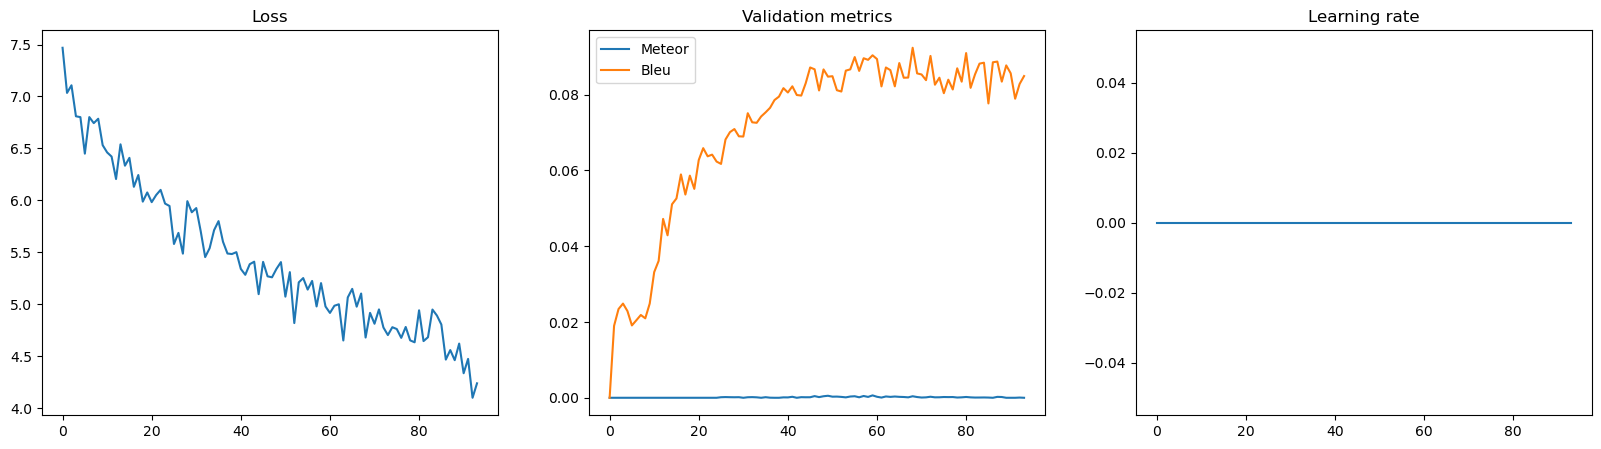

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(train_loss_list)
axs[0].set_title("Loss")
axs[1].plot(validation_meteor_list)
axs[1].plot(validation_bleu_list)
axs[1].legend(["Meteor", "Bleu"])
axs[1].set_title("Validation metrics")
axs[2].plot(train_lr_list)
axs[2].set_title("Learning rate")
plt.show()